In [1]:
%reset -f

Consider the Black-Shole equation for illiquid market \cite{gulen2022frechet} on spatial domain, $\mathcal{D}=[0,20]$ and time $t\in[0,0.25]$:
\begin{align}
    \begin{cases}
        \frac{\partial V}{\partial t} - \frac{\sigma^2 S^2}{2(1-\rho S \frac{\partial^2 V}{\partial S^2})^2} \frac{\partial^2 V}{\partial S^2}= 0 & (t,S)\in[0,0.25)\times(0,20) \\
        V(0.25,S) = max\{S-E,0\} &S\in(0,20)\\
        V(t,0)=0 &t\in[0,0.25) \\
        V(t,20)=Ee^{-rt} &t\in[0,0.25)
    \end{cases}
\end{align}

where $S, T=20, \sigma, and \rho$ stand for the stock price, the maturity date, the asset volatility, and a parameter measuring the market liquidity with $0<\rho<1$, respectively.

We solve this with parameters: $\sigma=0.2, \rho=0.02, r=0.03, E=10.$

In [2]:
from time import time

In [3]:
import tensorflow as tf
import numpy as np

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

sigma=tf.constant(0.2,dtype=DTYPE)
roo=tf.constant(0.02,dtype=DTYPE)
r=tf.constant(0.03,dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
k=10 #Known as E in the problem stated above

def fun_u_0(x):
  if x-k>0:
    return x-k
  else:
    return 0.0

def fun_u_b1(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

def fun_u_b2(t,x):
    return k*tf.exp(-r*t)

def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t - (0.5*(sigma**2)*(x**2)*u_xx)/(1-roo*x*u_xx)**2

In [4]:
N_0 = 80
N_b = 50
N_r = 1600

tmin = 0.
tmax = 0.25
xmin = 0.
xmax = 20.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

tf.random.set_seed(0)

t_0 = tf.ones((N_0,1), dtype=DTYPE)*ub[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

ui=[]
for xi in x_0:
  if fun_u_0(xi)!=0:
    ui.append(fun_u_0(xi).numpy()[0])
  else:
    ui.append(fun_u_0(xi))
tensor = tf.convert_to_tensor(ui)

u_0 = tf.expand_dims(tensor, axis=1)


In [5]:
t_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b1 = tf.ones([N_b,1])*lb[1]
t_b2 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b2 = tf.ones([N_b,1])*ub[1]
X_b1 = tf.concat([t_b1, x_b1], axis=1)
X_b2 = tf.concat([t_b2, x_b2], axis=1)

In [6]:
u_b1 = fun_u_b1(t_b1, x_b1)
u_b2 = fun_u_b2(t_b2, x_b2)


In [7]:
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collection of the boundary and inital data in lists
X_data = [X_0, X_b1, X_b2]
u_data = [u_0, u_b1, u_b2]

In [8]:
# x_0.shape,X_0.shape, u_0.shape, x_b.shape, X_b.shape, u_b.shape

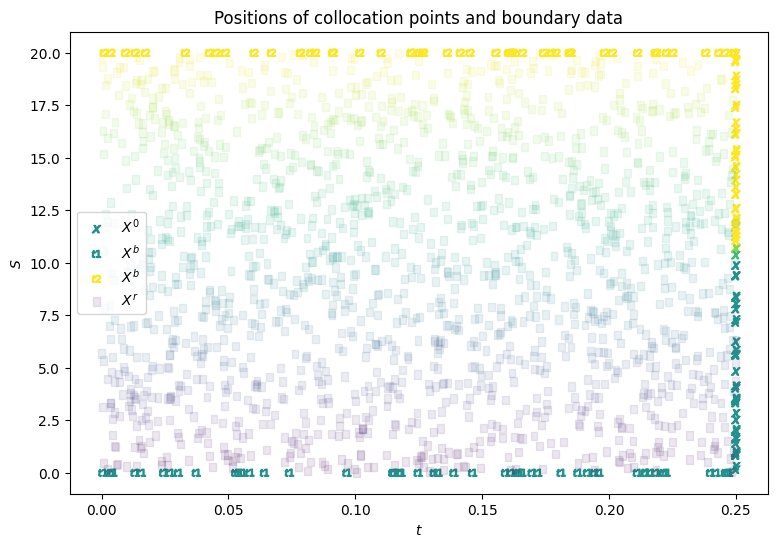

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='$x$', vmin=-1, vmax=1,label=f'$X^0$')
plt.scatter(t_b1, x_b1, c=u_b1, marker='$t1$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_b2, x_b2, c=u_b2, marker='$t2$', vmin=-1, vmax=1,label=f'$X^b$')
plt.scatter(t_r, x_r, c=x_r, marker='$.$', alpha=0.1,label=f'$X^r$')
plt.xlabel('$t$')
plt.ylabel('$S$')

plt.title('Positions of collocation points and boundary data');
plt.legend()
#plt.colorbar()
plt.show()
#plt.savefig('Xdata.png', bbox_inches='tight', dpi=300)

In [10]:
def init_model(num_hidden_layers=5, num_neurons_per_layer=20):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(2,)))

    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), kernel_initializer='glorot_normal'))

    model.add(tf.keras.layers.Dense(1))

    return model

In [11]:
def get_r(model, X_r):

    with tf.GradientTape(persistent=True) as tape:
        t, x = X_r[:, 0:1], X_r[:,1:2]

        tape.watch(t)
        tape.watch(x)

        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [12]:
def compute_loss(model, X_r, X_data, u_data):

    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    loss = phi_r

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [13]:
def get_grad(model, X_r, X_data, u_data):
    with tf.GradientTape(persistent=True) as tape:
        loss = compute_loss(model, X_r, X_data, u_data)

    grad_theta = tape.gradient(loss, model.trainable_variables)
    return loss, grad_theta

In [14]:
model = init_model()
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [15]:
from time import time

@tf.function
def train_step():
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

In [16]:
N = 4000
hist = []

t0 = time()

for i in range(N+1):

    loss = train_step()

    hist.append(loss.numpy())

    if i%100 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.29954132e+02
It 00100: loss = 1.12366289e-01
It 00200: loss = 7.46042281e-02
It 00300: loss = 5.74673377e-02
It 00400: loss = 4.20784056e-02
It 00500: loss = 3.16368453e-02
It 00600: loss = 2.39306260e-02
It 00700: loss = 1.85058638e-02
It 00800: loss = 1.68496501e-02
It 00900: loss = 1.11904331e-02
It 01000: loss = 9.35606565e-03
It 01100: loss = 9.22033284e-03
It 01200: loss = 9.09420755e-03
It 01300: loss = 8.96615721e-03
It 01400: loss = 8.83624330e-03
It 01500: loss = 8.70443787e-03
It 01600: loss = 8.57060868e-03
It 01700: loss = 8.43460299e-03
It 01800: loss = 8.29627551e-03
It 01900: loss = 8.15542787e-03
It 02000: loss = 8.01190175e-03
It 02100: loss = 7.86554255e-03
It 02200: loss = 7.71622220e-03
It 02300: loss = 7.56385690e-03
It 02400: loss = 7.40836374e-03
It 02500: loss = 7.24968594e-03
It 02600: loss = 7.08782999e-03
It 02700: loss = 6.92285458e-03
It 02800: loss = 6.75488589e-03
It 02900: loss = 6.58415165e-03
It 03000: loss = 6.41096476e-03
It 03100

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def plot_soln(model, Eq_name, N=600, lb=lb, ub=ub, save_fig = 'False'):
    tspace = np.linspace(lb[0], ub[0], N + 1)
    xspace = np.linspace(lb[1], ub[1], N + 1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T

    upred = model(tf.cast(Xgrid,DTYPE))
    U = upred.numpy().reshape(N+1,N+1)

    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis');
    ax.set_xlabel('$t$')
    ax.set_ylabel('$S$')
    ax.set_zlabel('$V_\\theta(t,x)$')
    ax.set_title(f'Solution of {Eq_name} equation');
    if save_fig == True:
        plt.savefig(f'Solution_{Eq_name}_Equations via PINNs.jpeg', bbox_inches='tight', dpi=300);
    plt.show()

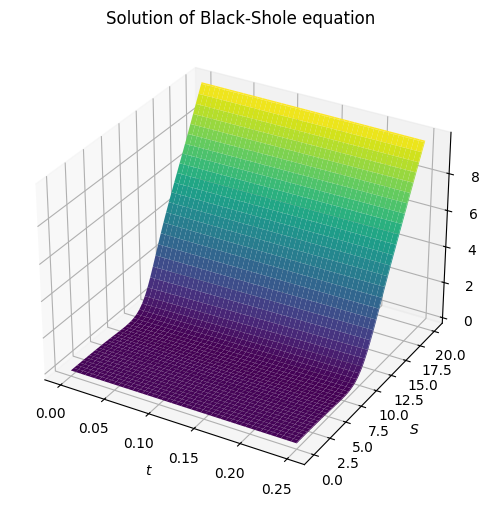

In [21]:
plot_soln(model, 'Black-Shole', save_fig=True)

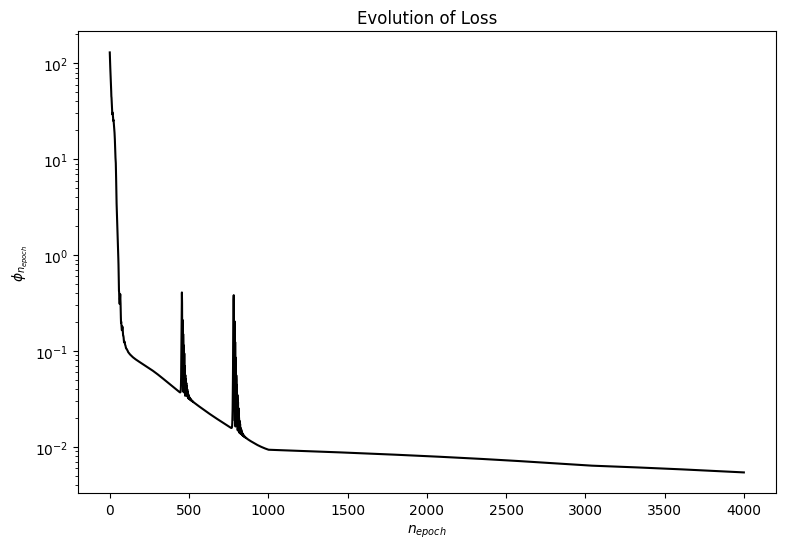

In [22]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');
plt.title('Evolution of Loss')
plt.show()